In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import xarray as xr

import sys
p = '/home/qnicolas/iac_notebooks/tools/'
if p not in sys.path:
    sys.path.append(p)
from generalTools import ddx, ddy, sel_months, quickplot, lon_360_to_180, wrap_lon, invert_latitudes

import cartopy.crs as ccrs

%load_ext autoreload
%autoreload 2

This notebook averages January NCEP-NCAR reanalysis data and calculates various forcing terms.
It is only provided to show the method used to calculate the forcing terms - the data is not provided. 

In [2]:
def calc_HTadv(ds):
    """Calculate horizontal heat advection"""
    return ds.U * ddx(ds.T) + ds.V * ddy(ds.T) 
def calc_VTadv(ds):
    """Calculate vertical heat advection"""
    return ds.W * (ds.T + ds.Z * 9.81/1004.).differentiate('level')/100.

In [3]:
def calc_MFD_U(ds):
    """Calculate total momentum flux divergence in U equation"""
    return ds.U * ddx(ds.U) + ds.V * ddy(ds.U) + ds.W * ds.U.differentiate('level')/100. - ds.U * ds.V * np.minimum(5.,np.maximum(-5.,np.tan(ds.lat * np.pi/180))) / 6.37122e6
def calc_MFD_V(ds):
    """Calculate total momentum flux divergence in V equation"""
    return ds.U * ddx(ds.V) + ds.V * ddy(ds.V) + ds.W * ds.V.differentiate('level')/100. + ds.U**2 * np.minimum(5.,np.maximum(-5.,np.tan(ds.lat * np.pi/180))) / 6.37122e6


In [4]:
path = "/net/atmos/data/ncep/reanalysis"
target_dir = "/net/helium/atmosdyn/qnicolas/ncep_means"

# Average NCEP-NCAR January data from 6-h values and calculate total heat flux and momentum flux divergences

In [ ]:
for year in range(1949,2000):
    print(year)
    T = sel_months(xr.open_dataset(f"{path}/pressure/air.{year}.nc"), [1,]).rename(air = 'T')
    U = sel_months(xr.open_dataset(f"{path}/pressure/uwnd.{year}.nc"), [1,]).rename(uwnd = 'U')
    V = sel_months(xr.open_dataset(f"{path}/pressure/vwnd.{year}.nc"), [1,]).rename(vwnd = 'V')
    W = sel_months(xr.open_dataset(f"{path}/pressure/omega.{year}.nc"), [1,]).rename(omega = 'W')
    Z = sel_months(xr.open_dataset(f"{path}/pressure/hgt.{year}.nc"), [1,]).rename(hgt = 'Z')
    SP = sel_months(xr.open_dataset(f"{path}/surface/pres.sfc.{year}.nc"), [1,]).rename(pres = 'SP')

    ds_jan = xr.merge([T, U, V, W, Z, SP])

    ds_jan.mean('time').to_netcdf(target_dir + f"/ncep_jan_{year}.nc")

    HFD = (calc_HTadv(ds_jan) + calc_VTadv(ds_jan)).mean('time').to_dataset(name='HFD')
    HFD.HFD.attrs['units'] = 'K/s'
    HFD.HFD.attrs['long_name'] = 'Total Heat Flux Divergence'
    HFD.to_netcdf(target_dir + f"/ncep_jan_HFD_{year}.nc")

    MFD = (calc_MFD_U(ds_jan)).mean('time').to_dataset(name='MFD_U')
    MFD['MFD_V'] = (calc_MFD_V(ds_jan)).mean('time')
    for var in 'MFD_U','MFD_V':
        MFD[var].attrs['units'] = 'm2/s2'
        MFD[var].attrs['long_name'] = f'Total Momentum Flux Divergence in {var[-1]} equation'
    MFD.to_netcdf(target_dir + f"/ncep_jan_MFD_{year}.nc")

1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


# Aggregate monthly averages and calculate diagnostics 

In [5]:
# instantiate dask client with 4 workers
from dask.distributed import Client
client = Client(n_workers=4,threads_per_worker=1,memory_limit='20G',dashboard_address=':40000')
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/qnicolas/proxy/40000/status,
Dashboard: /user/qnicolas/proxy/40000/status,Workers: 4
Total threads: 4,Total memory: 74.51 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36655,Workers: 4
Dashboard: /user/qnicolas/proxy/40000/status,Total threads: 4
Started: Just now,Total memory: 74.51 GiB
Comm: tcp://127.0.0.1:33243,Total threads: 1
Dashboard: /user/qnicolas/proxy/33607/status,Memory: 18.63 GiB
Nanny: tcp://127.0.0.1:43111,


In [12]:
ncep_jan_all = xr.open_mfdataset(target_dir + "/ncep_jan_*19*.nc", combine='nested', concat_dim='time',parallel=True,compat='override',coords='minimal')
ncep_jan_all_mean = lon_360_to_180(invert_latitudes(ncep_jan_all.mean('time').compute()))
ncep_jan_all_mean.to_netcdf(target_dir + "/ncep_jan_all_mean.nc")

In [13]:
ncep_jan_all_mean = xr.open_dataset(target_dir + "/ncep_jan_all_mean.nc")

In [17]:
Zsfc = xr.open_dataset(path + '/surface/hgt.sfc.nc').rename(hgt='ZSFC').ZSFC.isel(time=0)
Zsfc = lon_360_to_180(invert_latitudes(Zsfc))

In [18]:
QDIAB = ncep_jan_all_mean.HFD
MHFD = calc_HTadv(ncep_jan_all_mean) + calc_VTadv(ncep_jan_all_mean)
EHFD = QDIAB - MHFD
MMFD_U = calc_MFD_U(ncep_jan_all_mean)
MMFD_V = calc_MFD_V(ncep_jan_all_mean)
EMFD_U = ncep_jan_all_mean.MFD_U - MMFD_U
EMFD_V = ncep_jan_all_mean.MFD_V - MMFD_V


In [ ]:
# Calculating EMFD as a residual of the U,V equations - not appropriate since it ignores surface friction
# mfd_u = calc_MFD_U(ncep_jan_all_mean)
# mfd_v = calc_MFD_V(ncep_jan_all_mean)

# f = 2 * 2 * np.pi / 86400 * np.sin(ncep_jan_all_mean.lat * np.pi / 180)

# emfd_u = - mfd_u + f * ncep_jan_all_mean.V - ddx(ncep_jan_all_mean.Z)*9.81
# emfd_v = - mfd_v - f * ncep_jan_all_mean.U - ddy(ncep_jan_all_mean.Z)*9.81
# emfd_u[:,0] = 0.; emfd_u[:,-1] = 0.
# emfd_v[:,0] = 0.; emfd_v[:,-1] = 0.

In [19]:
basic_state = ncep_jan_all_mean[['U', 'V', 'W', 'T', 'SP']].mean('lon')
forcings = xr.merge([Zsfc, QDIAB.to_dataset(name = 'QDIAB'),  EHFD.to_dataset(name = 'EHFD'), EMFD_U.to_dataset(name='EMFD_U'), EMFD_V.to_dataset(name='EMFD_V'), ncep_jan_all_mean[['SP',]]])

In [20]:
basic_state.fillna(0.).rename(level='pressure').to_netcdf(target_dir + "/ncep_jan_basic_state.nc")
forcings.fillna(0.).rename(level='pressure') .to_netcdf(target_dir + "/ncep_jan_forcings.nc")

# Visualize forcings

In [30]:
forcings = xr.open_dataset(target_dir + "/ncep_jan_forcings.nc")

Text(0.5, 1.0, 'Qdiab diagnosed from NCEP as a residual of the thermo eqn')

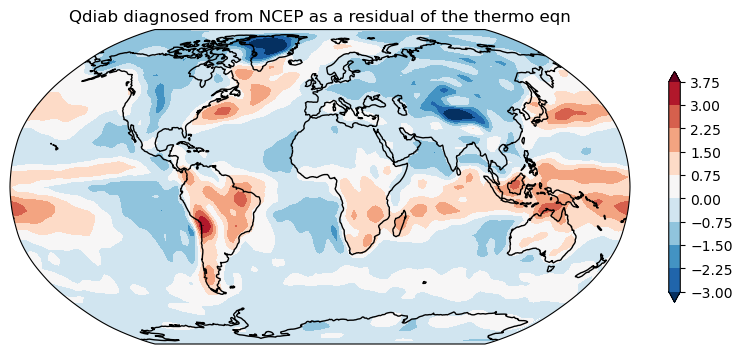

In [31]:
ax = quickplot(wrap_lon(forcings.QDIAB.fillna(0.).integrate('pressure') * 86400 / 990),fast=False,levels=np.arange(-3,3.76,0.75), cmap = 'RdBu_r',extend='both')
ax.set_title("Qdiab diagnosed from NCEP as a residual of the thermo eqn")

Text(0.5, 1.0, '300 hPa eddy zonal momentum flux convergence')

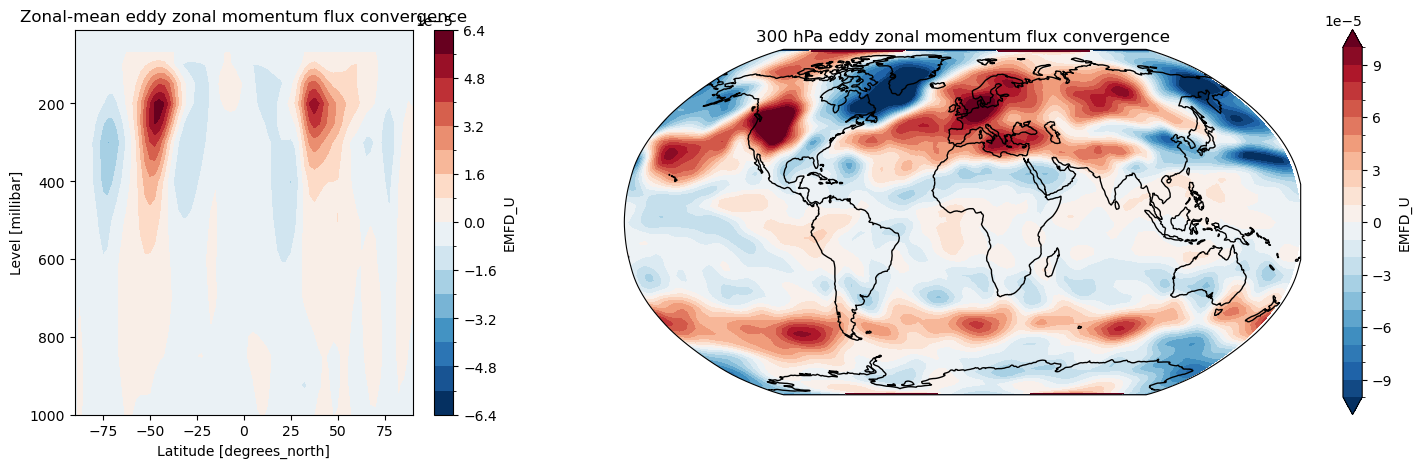

In [32]:
fig = plt.figure(figsize=(18,5))
gs = GridSpec(1, 2, width_ratios=[1, 2])

ax = fig.add_subplot(gs[0])
(-forcings.EMFD_U).mean('lon').plot.contourf(ax=ax,y='pressure',yincrease=False,levels=21)
ax.set_title("Zonal-mean eddy zonal momentum flux convergence")

ax = fig.add_subplot(gs[1], projection=ccrs.Robinson())
(-forcings.EMFD_U.sel(pressure=300)).plot.contourf(ax = ax, transform = ccrs.PlateCarree(),levels=np.linspace(-1e-4,1e-4,21), cmap = 'RdBu_r',extend='both')
ax.coastlines()
ax.set_title("300 hPa eddy zonal momentum flux convergence")

Text(0.5, 1.0, '300 hPa eddy heat flux convergence')

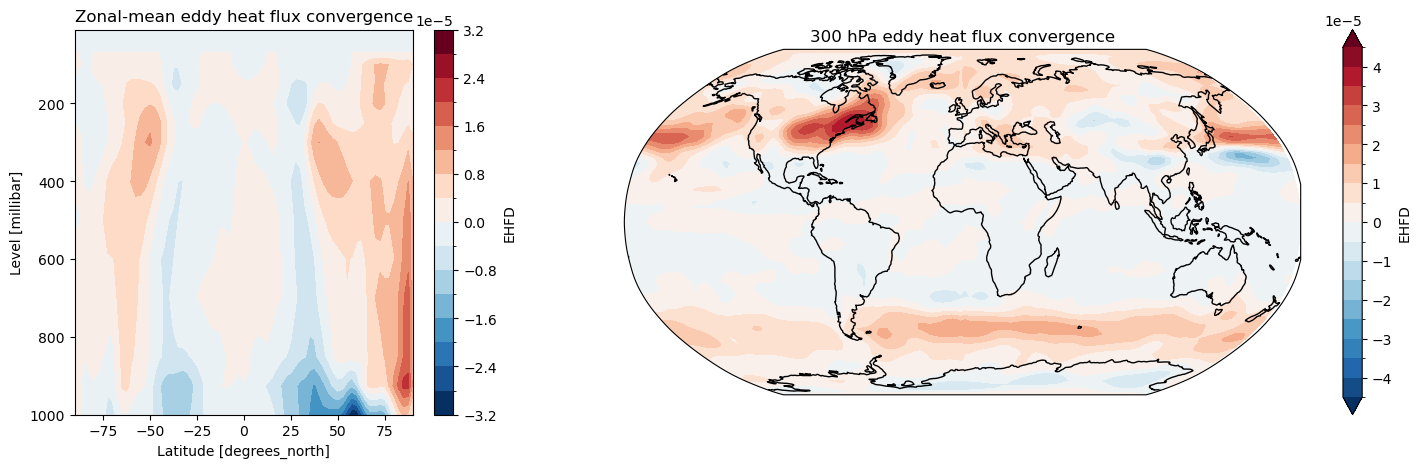

In [33]:
fig = plt.figure(figsize=(18,5))
gs = GridSpec(1, 2, width_ratios=[1, 2])

ax = fig.add_subplot(gs[0])
(-forcings.EHFD).mean('lon').plot.contourf(ax=ax,y='pressure',yincrease=False,levels=21)
ax.set_title("Zonal-mean eddy heat flux convergence")

ax = fig.add_subplot(gs[1], projection=ccrs.Robinson())
(-forcings.EHFD.sel(pressure=300)).plot.contourf(ax = ax, transform = ccrs.PlateCarree(),levels=21, cmap = 'RdBu_r',extend='both')
ax.coastlines()
ax.set_title("300 hPa eddy heat flux convergence")